<a href="https://colab.research.google.com/github/msuraj248/Keras_project/blob/master/sign-lang-dataset-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [96]:
train_data = pd.read_csv('drive/My Drive/sign_language/sign_mnist_train.csv')
test_data = pd.read_csv('drive/My Drive/sign_language/sign_mnist_test.csv')

In [82]:
train_data.shape , test_data.shape

((27455, 785), (7172, 785))

In [ ]:
s = (train_data.iloc[:, 1:]/255).values

In [13]:
train_data.shape, test_data.shape

((27455, 785), (7172, 785))

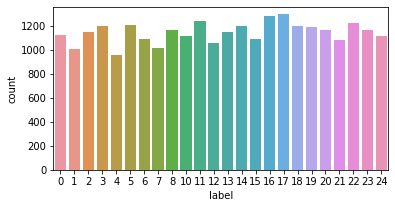

In [85]:
plt.figure(figsize=(6,3))
sns.countplot(train_data['label'])

In [97]:
encoder = OneHotEncoder() # encoding target variable i.e. label

x_train = (train_data.iloc[:, 1:]/255).values # normalizing train images to standard 0-1 pixel values.
y_train = encoder.fit_transform(train_data['label'].values.reshape(-1,1)).toarray()

x_test = (test_data.iloc[:, 1:]/255).values # normalizing test images to standard 0-1 pixel values.
y_test = encoder.fit_transform(test_data['label'].values.reshape(-1,1)).toarray()

In [24]:
x_train.shape , y_train.shape

((27455, 784), (27455, 24))

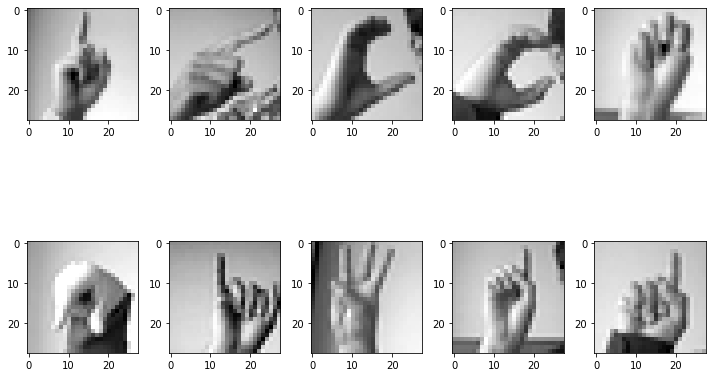

In [98]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()

In [99]:
input_width = 28
input_height = 28
input_channel = 1
input_pixels = 784

n_conv1 = 64
n_conv2 = 128
stride_conv1 = 1
stride_conv2 = 1
filter1_k = 5
filter2_k = 5
maxpool1_k = 2
maxpool2_k = 2

n_hidden = 1024
n_out = 24

input_size_to_hidden_layer = ((input_width//(maxpool1_k*maxpool2_k)) * (input_height//(maxpool1_k*maxpool2_k)) * n_conv2)


In [37]:
input_size_to_hidden_layer

6272

In [100]:
weights = {
    'wc1' : tf.Variable(tf.random.normal([filter1_k, filter1_k, input_channel, n_conv1])), # weight corresponding to convolutional layer1.
    'wc2' : tf.Variable(tf.random.normal([filter2_k, filter2_k, n_conv1, n_conv2])), # weight corresponding to convolutional layer2.
    'wh' : tf.Variable(tf.random.normal([input_size_to_hidden_layer, n_hidden])),  # weight corresponding to hidden layer.
    'wo' : tf.Variable(tf.random.normal([n_hidden, n_out])) # weight corresponding to output layer.
}

biases = {
    'bc1' : tf.Variable(tf.random.normal([n_conv1])), # biases corresponding to convolutional layer1.
    'bc2' : tf.Variable(tf.random.normal([n_conv2])), # biases corresponding to convolutional layer2.
    'bh' : tf.Variable(tf.random.normal([n_hidden])), # biases corresponding to hidden layer.
    'bo' : tf.Variable(tf.random.normal([n_out])) # biases corresponding to output layer.
}

In [101]:
# function to get the output from a convolutional layer.
def conv(x, weights, bias, stride = 1):
    output = tf.nn.conv2d(x, weights, padding='SAME', strides=[1, stride, stride, 1])
    output = tf.nn.bias_add(output, bias)
    output = tf.nn.relu(output) # applying activation function.
    return output

In [102]:
# function which return output of pooling layer used to decrease image size so that we have to train less weights and biases.
def maxpooling(x, k):
    return tf.nn.max_pool(x, padding='SAME', ksize=[1, k, k, 1], strides=[1, k, k, 1])


In [103]:
def forward_propagation(x, weights, biases):
    x = tf.reshape(x, shape = [-1, input_width, input_height, input_channel])
    
    conv1 = conv(x, weights['wc1'], biases['bc1'], stride_conv1)
    conv1_pool = maxpooling(conv1, maxpool1_k)
    
    conv2 = conv(conv1_pool, weights['wc2'], biases['bc2'], stride_conv2)
    conv2_pool = maxpooling(conv2, maxpool2_k)
    
    hidden_layer_input = tf.reshape(conv2_pool, shape = [-1, input_size_to_hidden_layer])
    hidden_layer_output = tf.nn.relu(tf.add(tf.matmul(hidden_layer_input, weights['wh']), biases['bh']))
    
    output = tf.add(tf.matmul(hidden_layer_output, weights['wo']), biases['bo'])
    return output

In [104]:
X = tf.compat.v1.placeholder(tf.float32, [ None, input_pixels], name='x')
Y = tf.compat.v1.placeholder(tf.int32, [ None, n_out], name='y')
pred = forward_propagation(X, weights, biases)

In [105]:
cost = tf.reduce_mean(tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=Y))

# using adam optimizer on the cost.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.011)
optimize = optimizer.minimize(cost)

In [106]:
# creating a new session of tensorflow.
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

In [56]:
batch_size=64
a = 0
for i in range(10):
    num_batches = int(len(x_train)/batch_size)
    total_cost = 0
    for j in range(num_batches):
        batch_x = x_train[a: a+batch_size]
        batch_y = y_train[a: a+batch_size]
        c, _ = sess.run([cost, optimize], feed_dict={X:batch_x, Y:batch_y})
        total_cost += c
        a += batch_size
    a = 0
    print('total cost at',i+1,'iteration:',total_cost)

total cost at 1 iteration: 3773826.174682617
total cost at 2 iteration: 11864.9140817374
total cost at 3 iteration: 5024.216990592595
total cost at 4 iteration: 4756.72171650044
total cost at 5 iteration: 4220.925852895643
total cost at 6 iteration: 4270.919076547056
total cost at 7 iteration: 6194.838629635357
total cost at 8 iteration: 5768.52038297852
total cost at 9 iteration: 2001.5246364746176
total cost at 10 iteration: 4404.354074074525


In [76]:
# testing model with training data.
predictions = tf.argmax(pred, axis=1)
correct_labels = tf.argmax(Y, axis=1)
accuracy = tf.equal(predictions, correct_labels)
predictions, labels, accuracy = sess.run([predictions, correct_labels, accuracy], feed_dict={X:x_train, Y:y_train})
accuracy.sum()/len(x_train)

0.9584410854124932

In [ ]:
# testing model with testing data.
predictions = tf.argmax(pred, axis=1)
correct_labels = tf.argmax(Y, axis=1)
accuracy = tf.equal(predictions, correct_labels)
predictions, labels, accuracy = sess.run([predictions, correct_labels, accuracy], feed_dict={X:x_test, Y:y_test})
accuracy.sum()/len(x_test)